### Consotrium to connect MapD to PyGDF to H2OAIGLM

### In this demo, we will train 4000 regularized linear regression models on the U.S. Census dataset, with the goal to predict the income of a person, given approximately 10000 data points (such as age, occupation, zip code, etc.)

### The dataset is about 2GB in memory (50k rows, 10k cols, single-precision floating-point values), so it fits onto the GPU memory.

### By using multiple GPUs, we are able to speed up this process significantly, and can train about 40 models per second (on a DGX-1 with 8 GPUs)

### Choose to Run or Run+Animate

In [1]:
# run=0: Choose not run h2oaiglm and just pass through all other cells
# run=1: Run h2oaiglm without animation
# Requirements: python3.5
run=1

# anim=0: Don't show animation
# anim=1: Do show animation
# pip install pandas psutil matplotlib --user
# pip install -e git+https://github.com/fbcotter/py3nvml#egg=py3nvml --user
anim=1

PWD = !pwd

In [2]:
import sys
import os.path
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

Add import path to MapD Thrift binding and Arrow schema

In [3]:
thirdparty_path = os.path.join(PWD[0], '..', 'thirdparty')
sys.path.append(thirdparty_path)
thirdparty_path

'/home/vinod/Downloads/pygdf/notebooks/../thirdparty'

If `pygdf` cannot be imported, uncomment code below:

In [4]:
pygdf_path = os.path.join(PWD[0], '..')
sys.path.append(pygdf_path)

In [5]:
import pygdf

In [6]:
from thrift.protocol import TBinaryProtocol
from thrift.protocol import TJSONProtocol
from thrift.transport import TSocket
from thrift.transport import THttpClient
from thrift.transport import TTransport

In [7]:
from mapd import MapD
from mapd import ttypes

MapD connection

In [8]:
def get_client(host_or_uri, port, http):
  if http:
    transport = THttpClient.THttpClient(host_or_uri)
    protocol = TJSONProtocol.TJSONProtocol(transport)
  else:
    socket = TSocket.TSocket(host_or_uri, port)
    transport = TTransport.TBufferedTransport(socket)
    protocol = TBinaryProtocol.TBinaryProtocol(transport)

  client = MapD.Client(protocol)
  transport.open()
  return client

In [9]:
db_name = 'mapd'
user_name = 'mapd'
passwd = 'HyperInteractive'
hostname = 'localhost'
portno = 9091

client = get_client(hostname, portno, False)
session = client.connect(user_name, passwd, db_name)
print('Connection complete')

Connection complete


The Query

In [10]:
columns = """
INCEARN,RECTYPE,IPUMS_YEAR,DATANUM,SERIAL,NUMPREC,SUBSAMP,HHWT,HHTYPE,REPWT,ADJUST,CPI99,REGION,STATEICP,STATEFIP,COUNTY,COUNTYFIPS,METRO,METAREA,METAREAD,MET2013,MET2013ERR,CITY,CITYERR,CITYPOP,PUMA,PUMARES2MIG,STRATA,PUMASUPR,CONSPUMA,CPUMA0010,APPAL,APPALD,HOMELAND,MET2003,CNTRY,GQ,GQTYPE,GQTYPED,FARM,OWNERSHP,OWNERSHPD,MORTGAGE,MORTGAG2,COMMUSE,FARMPROD,ACREHOUS,MORTAMT1,MORTAMT2,TAXINCL,INSINCL,PROPINSR,PROPTX99,OWNCOST,RENT,RENTGRS,RENTMEAL,CONDOFEE,MOBLHOME,MOBLHOM2,MOBLOAN,SECRES,SECRESMO,SECRESRE,COSTELEC,COSTGAS,COSTWATR,COSTFUEL,PUBHOUS,RENTSUB,HEATSUB,LUNCHSUB,FOODSTMP,FDSTPAMT,VALUEH,LINGISOL,VACANCY,KITCHEN,KITCHENORIG,FRIDGE,FRIDGEORIG,SINK,STOVE,ROOMS,ROOMSORIG,PLUMBING,HOTWATER,SHOWER,TOILET,BUILTYR,BUILTYR2,UNITSSTR,BEDROOMS,BEDROOMSORIG,PHONE,PHONEORIG,CILAPTOP,CIHAND,CIOTHCOMP,CINETHH,CIMODEM,CISAT,CIDSL,CIFIBER,CIBRDBND,CIDIAL,CIOTHSVC,FUELHEAT,VEHICLES,SSMC,NFAMS,NSUBFAM,NCOUPLES,NMOTHERS,NFATHERS,MULTGEN,MULTGEND,CBNSUBFAM,REPWT1,REPWT2,REPWT3,REPWT4,REPWT5,REPWT6,REPWT7,REPWT8,REPWT9,REPWT10,REPWT11,REPWT12,REPWT13,REPWT14,REPWT15,REPWT16,REPWT17,REPWT18,REPWT19,REPWT20,REPWT21,REPWT22,REPWT23,REPWT24,REPWT25,REPWT26,REPWT27,REPWT28,REPWT29,REPWT30,REPWT31,REPWT32,REPWT33,REPWT34,REPWT35,REPWT36,REPWT37,REPWT38,REPWT39,REPWT40,REPWT41,REPWT42,REPWT43,REPWT44,REPWT45,REPWT46,REPWT47,REPWT48,REPWT49,REPWT50,REPWT51,REPWT52,REPWT53,REPWT54,REPWT55,REPWT56,REPWT57,REPWT58,REPWT59,REPWT60,REPWT61,REPWT62,REPWT63,REPWT64,REPWT65,REPWT66,REPWT67,REPWT68,REPWT69,REPWT70,REPWT71,REPWT72,REPWT73,REPWT74,REPWT75,REPWT76,REPWT77,REPWT78,REPWT79,REPWT80,RESPMODE,PERNUM,PERWT,SLWT,REPWTP,FAMSIZE,NCHILD,NCHLT5,FAMUNIT,ELDCH,YNGCH,NSIBS,MOMLOC,STEPMOM,MOMRULE,POPLOC,STEPPOP,POPRULE,SPLOC,SPRULE,SUBFAM,SFTYPE,SFRELATE,CBSUBFAM,CBSFTYPE,CBSFRELATE,RELATE,RELATED,SEX,AGE,AGEORIG,BIRTHQTR,MARST,BIRTHYR,MARRNO,MARRINYR,YRMARR,DIVINYR,WIDINYR,FERTYR,RACE,RACED,HISPAN,HISPAND,BPL,BPLD,ANCESTR1,ANCESTR1D,ANCESTR2,ANCESTR2D,CITIZEN,YRNATUR,YRIMMIG,YRSUSA1,YRSUSA2,SPOKEN_LANGUAGE,LANGUAGED,SPEAKENG,TRIBE,TRIBED,RACESING,RACESINGD,RACAMIND,RACASIAN,RACBLK,RACPACIS,RACWHT,RACOTHER,RACNUM,SCHOOL,EDUC,EDUCD,GRADEATT,GRADEATTD,SCHLTYPE,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,EMPSTATD,LABFORCE,OCC,OCC1950,OCC1990,OCC2010,IND,IND1950,IND1990,CLASSWKR,CLASSWKRD,OCCSOC,INDNAICS,WKSWORK1,WKSWORK2,UHRSWORK,WRKLSTWK,ABSENT,LOOKING,AVAILBLE,WRKRECAL,WORKEDYR,POVERTY,OCCSCORE,SEI,HWSEI,PRESGL,PRENT,ERSCOR50,ERSCOR90,EDSCOR50,EDSCOR90,NPBOSS50,NPBOSS90,MIGRATE1,MIGRATE1D,MIGPLAC1,MIGMET1,MIGTYPE1,MIGCITY1,MIGPUMS1,MIGPUMA1,MOVEDIN,MOVEDINORIG,DISABWRK,VETDISAB,DIFFREM,DIFFPHYS,DIFFMOB,DIFFCARE,DIFFSENS,DIFFEYE,DIFFHEAR,VETSTAT,VETSTATD,VET01LTR,VET95X00,VET90X01,VET90X95,VET75X90,VET80X90,VET75X80,VETVIETN,VET55X64,VETKOREA,VET47X50,VETWWII,VETOTHER,VETYRS,PWSTATE2,PWMETRO,PWCITY,PWTYPE,PWPUMA00,PWPUMAS,TRANWORK,CARPOOL,RIDERS,TRANTIME,DEPARTS,ARRIVES,GCHOUSE,GCMONTHS,GCRESPON,PROBAI,PROBAPI,PROBBLK,PROBOTH,PROBWHT,REPWTP1,REPWTP2,REPWTP3,REPWTP4,REPWTP5,REPWTP6,REPWTP7,REPWTP8,REPWTP9,REPWTP10,REPWTP11,REPWTP12,REPWTP13,REPWTP14,REPWTP15,REPWTP16,REPWTP17,REPWTP18,REPWTP19,REPWTP20,REPWTP21,REPWTP22,REPWTP23,REPWTP24,REPWTP25,REPWTP26,REPWTP27,REPWTP28,REPWTP29,REPWTP30,REPWTP31,REPWTP32,REPWTP33,REPWTP34,REPWTP35,REPWTP36,REPWTP37,REPWTP38,REPWTP39,REPWTP40,REPWTP41,REPWTP42,REPWTP43,REPWTP44,REPWTP45,REPWTP46,REPWTP47,REPWTP48,REPWTP49,REPWTP50,REPWTP51,REPWTP52,REPWTP53,REPWTP54,REPWTP55,REPWTP56,REPWTP57,REPWTP58,REPWTP59,REPWTP60,REPWTP61,REPWTP62,REPWTP63,REPWTP64,REPWTP65,REPWTP66,REPWTP67,REPWTP68,REPWTP69,REPWTP70,REPWTP71,REPWTP72,REPWTP73,REPWTP74,REPWTP75,REPWTP76,REPWTP77,REPWTP78,REPWTP79,REPWTP80
""".strip()
print(len(columns.split(',')))

447


In [11]:
query = "SELECT {} FROM ipums_easy WHERE INCEARN > 100;".format(columns)
print('Query is : ' + query)

# always use True for is columnar
results = client.sql_execute_cudf(session, query, device_id=0, first_n=-1)

Query is : SELECT INCEARN,RECTYPE,IPUMS_YEAR,DATANUM,SERIAL,NUMPREC,SUBSAMP,HHWT,HHTYPE,REPWT,ADJUST,CPI99,REGION,STATEICP,STATEFIP,COUNTY,COUNTYFIPS,METRO,METAREA,METAREAD,MET2013,MET2013ERR,CITY,CITYERR,CITYPOP,PUMA,PUMARES2MIG,STRATA,PUMASUPR,CONSPUMA,CPUMA0010,APPAL,APPALD,HOMELAND,MET2003,CNTRY,GQ,GQTYPE,GQTYPED,FARM,OWNERSHP,OWNERSHPD,MORTGAGE,MORTGAG2,COMMUSE,FARMPROD,ACREHOUS,MORTAMT1,MORTAMT2,TAXINCL,INSINCL,PROPINSR,PROPTX99,OWNCOST,RENT,RENTGRS,RENTMEAL,CONDOFEE,MOBLHOME,MOBLHOM2,MOBLOAN,SECRES,SECRESMO,SECRESRE,COSTELEC,COSTGAS,COSTWATR,COSTFUEL,PUBHOUS,RENTSUB,HEATSUB,LUNCHSUB,FOODSTMP,FDSTPAMT,VALUEH,LINGISOL,VACANCY,KITCHEN,KITCHENORIG,FRIDGE,FRIDGEORIG,SINK,STOVE,ROOMS,ROOMSORIG,PLUMBING,HOTWATER,SHOWER,TOILET,BUILTYR,BUILTYR2,UNITSSTR,BEDROOMS,BEDROOMSORIG,PHONE,PHONEORIG,CILAPTOP,CIHAND,CIOTHCOMP,CINETHH,CIMODEM,CISAT,CIDSL,CIFIBER,CIBRDBND,CIDIAL,CIOTHSVC,FUELHEAT,VEHICLES,SSMC,NFAMS,NSUBFAM,NCOUPLES,NMOTHERS,NFATHERS,MULTGEN,MULTGEND,CBNSUBFAM,REPWT1,REPWT2,REPWT3,R

In [12]:
from numba import cuda
from numba.cuda.cudadrv import drvapi

In [13]:
ipc_handle = drvapi.cu_ipc_mem_handle(*results.df_handle)
ipch = cuda.driver.IpcHandle(None, ipc_handle, size=results.df_size)
ctx = cuda.current_context()
dptr = ipch.open(ctx)

dptr

`dptr` is GPU memory containing the query result

Convert `dptr` into a GPU device ndarray (numpy array like object on GPU)

In [14]:
import numpy as np

In [15]:
dtype = np.dtype(np.byte)
darr = cuda.devicearray.DeviceNDArray(shape=dptr.size, strides=dtype.itemsize, dtype=dtype, gpu_data=dptr)

Use PyGDF to read the arrow metadata from the query

In [16]:
from pygdf.gpuarrow import GpuArrowReader

In [17]:
reader = GpuArrowReader(darr)

Wrap result in a Python CUDA DataFrame

In [18]:
from pygdf.dataframe import DataFrame

In [19]:
df = DataFrame(reader.to_dict().items())

In [20]:
df['INCEARN'].mean()

32876.621408045976

Preprocess the data

In [21]:
num_cols = set()
cat_cols = set()
response_set = set(['INCEARN'])
feature_names = set(df.columns) - response_set

Determine categorical and numeric columns.  Compute unique values from categorical columns.

In [22]:
uniques = {}
for k in feature_names:
    try:
        uniquevals = df[k].unique_k(k=1000)
        uniques[k] = uniquevals
    except ValueError:
        # more than 1000 unique values
        num_cols.add(k)
    else:
        # within 1000 unique values
        nunique = len(uniquevals)
        if nunique < 2:
            del df[k]        # drop constant column
        elif 1 < nunique < 1000:
            cat_cols.add(k)  # as cat column
        else:
            num_cols.add(k)  # as num column

Fix numeric columns.  Fill NA, Scale to [0, 1]. Drop near constant

In [23]:
for k in (num_cols - response_set):
    df[k] = df[k].fillna(df[k].mean())
    assert df[k].null_count == 0
    std = df[k].std()
    # drop near constant columns
    if not np.isfinite(std) or std < 1e-4:
        del df[k]
        print('drop near constant', k)
    else:
        df[k] = df[k].scale()

Expand categorical columns

In [24]:
for k in cat_cols:
    cats = uniques[k][1:]  # drop first
    df = df.one_hot_encoding(k, prefix=k, cats=cats)
    del df[k]

Ensure INCEARN is float64

In [25]:
nrows=len(df)
print(nrows)
df['intercept'] = np.ones(nrows, dtype=np.float64)

5568


In [26]:
df['INCEARN'] = df['INCEARN'].astype(np.float64)

In [27]:
# Print dtypes
{df[k].dtype for k in df.columns}

{dtype('float64')}

Create 60-40: training - testing

In [28]:
n60 = int(len(df) * 0.6)
print('60% of {} is {}'.format(len(df), n60))
train_df = df.loc[:n60]
test_df = df.loc[n60:]
print('train_df has {} rows | test_df has {} rows'.format(len(train_df), len(test_df)))

60% of 5568 is 3340
train_df has 3340 rows | test_df has 2228 rows


Turn the dataframes into a matrix

In [29]:
train_data_mat = train_df.as_gpu_matrix(columns=df.columns[1:])
train_result_mat = train_df.as_gpu_matrix(columns=[df.columns[0]])
test_data_mat = test_df.as_gpu_matrix(columns=df.columns[1:])
test_result_mat = test_df.as_gpu_matrix(columns=[df.columns[0]])

In [30]:
#print(train_df.as_matrix(columns=[df.columns[0]]))

In [31]:
print(train_df['INCEARN'].mean())
print(test_df['INCEARN'].mean())

33133.4341317
32491.6328546


In [32]:
train_data_mat.shape, train_result_mat.shape, test_data_mat.shape, test_result_mat.shape

((3340, 8550), (3340, 1), (2228, 8550), (2228, 1))

Cleanup the IPC handle.

Note: `.as_gpu_matrix()` has created new copies; thus, we can close the IPC handle.

In [33]:
ipch.close()

The ctypes pointer to the gpu matrices

In [34]:
train_data_mat_ptr = train_data_mat.device_ctypes_pointer
train_result_mat_ptr = train_result_mat.device_ctypes_pointer
test_data_mat_ptr = test_data_mat.device_ctypes_pointer
test_result_mat_ptr = test_result_mat.device_ctypes_pointer

In [35]:
print('train_data_mat_ptr address', hex(train_data_mat_ptr.value))
print('train_result_mat_ptr address', hex(train_result_mat_ptr.value))
print('test_data_mat_ptr address', hex(test_data_mat_ptr.value))
print('test_result_mat_ptr address', hex(test_result_mat_ptr.value))

train_data_mat_ptr address 0x10323200000
train_result_mat_ptr address 0x1032300ae00
test_data_mat_ptr address 0x10330c00000
test_result_mat_ptr address 0x10323011800


In [36]:
import os
os.getcwd()

'/home/vinod/Downloads/pygdf/notebooks'

### Import H2OAIGLM

In [37]:
# Load H2OAIGLM
import h2oaiglm as h2oaiglm
from ctypes import *
import time
if anim==1:
    import pandas as pd



Loaded H2OAIGLM CPU library

Loaded H2OAIGLM GPU library.


### Define some helper methods for plotting and running the algorithm

In [38]:
def new_alpha(row_fold):
    if row_fold == 0:
        return -0.025
    elif row_fold == 1:
        return -0.05
    elif row_fold == 3:
        return 0.025
    elif row_fold == 4:
        return 0.05
    else: return 0

def plot_cpu_perf(axis, cpu_labels, cpu_snapshot):
    axis.cla()
    axis.grid(False)
    axis.set_ylim([0,100])
    axis.set_ylabel('Percent', labelpad=2, fontsize = 14)
    axis.bar(cpu_labels, cpu_snapshot, color='dodgerblue')
    axis.set_title('CPU Utilization', fontsize = 16)
    
def plot_gpu_perf(axis, gpu_labels, gpu_snapshot):
    axis.cla()
    axis.grid(False)
    axis.set_ylim([0,100])
    axis.set_xticks(gpu_labels)
    axis.set_ylabel('Percent', labelpad=2, fontsize = 14)
    axis.bar(gpu_labels, gpu_snapshot, width =0.5, color = 'limegreen')
    axis.set_title('GPU Utilization', fontsize = 16)
    
def plot_glm_results(axis, results, best_rmse, cb):
    axis.cla()
    axis.set_xscale('log')
    axis.set_xlim([0.1, 1e9])
    axis.set_ylim([-0.12, 1.12])
    axis.set_yticks([x/7. for x in range(0,8)])
    axis.set_ylabel('Parameter 1:  '+r'$\alpha$', fontsize = 16)
    axis.set_xlabel('Parameter 2:  '+r'$\lambda$', fontsize = 16)
    num_models = min(4000,int(4000*results.shape[0]/2570))
    axis.set_title('Elastic Net Models Trained and Evaluated: ' + str(num_models), fontsize = 16)

    try:
        cm = ListedColormap(sns.color_palette("RdYlGn", 10).as_hex())
        cf = axis.scatter(results['lambda'], results['alpha_prime'], c=results['rel_acc'], 
                    cmap=cm, vmin=0, vmax=1)
        axis.plot(best_rmse['lambda'],best_rmse['alpha_prime'], 'o',
            ms=15, mec='k', mfc='none', mew=2)

        if not cb:
            cb = pl.colorbar(cf, ax=axis)
            cb.set_label('Relative  Validation  Accuracy', rotation=270, 
                         labelpad=18, fontsize = 16)   
        cb.update_normal(cf)
    except:
        #print("plot_glm_results exception -- no frame")
        pass

from py3nvml.py3nvml import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style("whitegrid")
import psutil
import numpy as np
import pylab as pl
from IPython import display
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import sys
import subprocess
maxNGPUS = int(subprocess.check_output("nvidia-smi -L | wc -l", shell=True))
print("Maximum Number of GPUS:", maxNGPUS)

nvmlInit()
deviceCount = nvmlDeviceGetCount()
for i in range(deviceCount):
    handle = nvmlDeviceGetHandleByIndex(i)
    #print("Device {}: {}".format(i, nvmlDeviceGetName(handle)))
    #print ("Driver Version:", nvmlSystemGetDriverVersion())

import os
def RunAnimation(arg):
    deviceCount = arg
    file = os.getcwd() + "/rmse.txt"
    fig = pl.figure(figsize = (9,9))
    pl.rcParams['xtick.labelsize'] = 14
    pl.rcParams['ytick.labelsize'] = 14
    gs = gridspec.GridSpec(3, 2, wspace=0.3, hspace=0.4)
    ax1 = pl.subplot(gs[0,-2])
    ax2 = pl.subplot(gs[0,1])
    ax3 = pl.subplot(gs[1:,:])
    fig.suptitle('H2O.ai Machine Learning $-$ Generalized Linear Modeling', size=18)

    pl.gcf().subplots_adjust(bottom=0.2)

    cb = False
    os.system("mkdir -p images")
    i=0
    while(True):
        try:
            #cpu
            snapshot = psutil.cpu_percent(percpu=True)
            cpu_labels = range(1,len(snapshot)+1)
            plot_cpu_perf(ax1, cpu_labels, snapshot)
    
            #gpu
            gpu_snapshot = []
            gpu_labels = list(range(1,deviceCount+1))
            for j in range(deviceCount):
                handle = nvmlDeviceGetHandleByIndex(j)
                util = nvmlDeviceGetUtilizationRates(handle)
                gpu_snapshot.append(util.gpu)
            gpu_snapshot = gpu_snapshot   
            plot_gpu_perf(ax2, gpu_labels, gpu_snapshot)
    
            res = pd.read_csv(file, sep="\s+",header=None,names=['time','pass','fold','a','i','alpha','lambda','trainrmse','ivalidrmse','validrmse'])
            
            res['rel_acc'] = ((38000- res['validrmse'])/(38000-28000))
            res['alpha_prime'] = res['alpha'] + res['fold'].apply(lambda x: new_alpha(x))

            best = res.ix[res['rel_acc']==np.max(res['rel_acc']),:]
            plot_glm_results(ax3, res, best.tail(1), cb)
            # flag for colorbar to avoid redrawing
            cb = True

            # Add footnotes
            footnote_text = "*U.S. Census dataset (predict Income): 45k rows, 10k cols\nParameters: 5-fold cross-validation, " + r'$\alpha = \{\frac{i}{7},i=0\ldots7\}$' + ", "\
   'full $\lambda$-' + "search"
            #pl.figtext(.05, -.04, footnote_text, fontsize = 14,)
            pl.annotate(footnote_text, (0,0), (-30, -50), fontsize = 12,
                        xycoords='axes fraction', textcoords='offset points', va='top')

            #update the graphics
            display.display(pl.gcf())
            display.clear_output(wait=True)
            time.sleep(0.01)

            #save the images
            saveimage=0
            if saveimage:
                file_name = './images/glm_run_%04d.png' % (i,)
                pl.savefig(file_name, dpi=200)
            i=i+1
        
        except KeyboardInterrupt:
            break
        #except:
        #    #print("Could not Create Frame")
        #    pass

Maximum Number of GPUS: 2


### Choose Data Size and Order and How was processed for H2OAIGLM

In [39]:
intercept = 1 #
validFraction=0.4
standardize = 0
n=train_data_mat.shape[1]
mTrain=train_data_mat.shape[0]
mValid=test_data_mat.shape[0]
print("n=%d mTrain=%d mValid=%d" % (n,mTrain,mValid))
# Order of data
fortran = 1
print("fortran=%d" % (fortran))
result={df[k].dtype for k in df.columns}
print(result)
print(fortran)
if result.pop() == np.dtype('float64'):
    print("double precision")
    precision=1
else:
    print("single precision")
    precision=0

n=8550 mTrain=3340 mValid=2228
fortran=1
{dtype('float64')}
1
double precision


### Help function to use Mapd->pygdf data pointers in GPU on H2OAIGLM

In [40]:
def RunH2Oaiglm(arg):
    intercept,standardize, lambda_min_ratio, nFolds, nAlphas, nLambdas, nGPUs = arg
    
        # set solver cpu/gpu according to input args
    if((nGPUs>0) and (h2oaiglm.ElasticNetSolverGPU is None)):
        print("\nGPU solver unavailable, using CPU solver\n")
        nGPUs=0

    sharedA = 0
    sourceme = 0
    sourceDev = 0
    nThreads = 1 if(nGPUs==0) else nGPUs # not required number of threads, but normal.  Bit more optimal to use 2 threads for CPU, but 1 thread per GPU is optimal.

    #print("Setting up Solver")
    os.system("rm -f rmse.txt ; touch rmse.txt ; rm -f varimp.txt ; touch varimp.txt")
    Solver = h2oaiglm.ElasticNetSolverGPU if(nGPUs>0) else h2oaiglm.ElasticNetSolverCPU


    #  Solver = h2oaiglm.ElasticNetSolverCPU
    assert Solver != None, "Couldn't instantiate ElasticNetSolver"
    enet = Solver(sharedA, nThreads, nGPUs, 'c' if fortran else 'r', intercept, standardize, lambda_min_ratio, nLambdas, nFolds, nAlphas)

    # grab mapd-continuum pointers
    a=c_void_p(train_data_mat_ptr.value)
    b=c_void_p(train_result_mat_ptr.value)
    c=c_void_p(test_data_mat_ptr.value)
    d=c_void_p(test_result_mat_ptr.value)
    e=c_void_p(0)

    print("Solving")
    ## Solve
    t0 = time.time()
    print("vars: %d %d %d %d %d %d %d" % (sourceDev, mTrain, n, mValid, intercept, standardize, precision))
    enet.fit(sourceDev, mTrain, n, mValid, intercept, standardize, precision, a, b, c, d, e)
    t1 = time.time()
    print("Done Solving")
    print("Time to train H2O AI GLM: %r" % (t1-t0))

### Train 4000 Elastic Net Models (5-fold cross-validation, 8 $\alpha$ values, 100 $\lambda$ values)

In [ ]:
lambda_min_ratio=1E-9
nFolds=5
nAlphas=8
nLambdas=100
nGPUs=maxNGPUS # choose all GPUs


if run==1 and anim==0:
    # Run Model
    arg = intercept,standardize, lambda_min_ratio, nFolds, nAlphas, nLambdas, nGPUs 
    RunH2Oaiglm(arg)

if run==1 and anim==1:
    from threading import Thread

    # Run Model
    arg = intercept,standardize, lambda_min_ratio, nFolds, nAlphas, nLambdas, nGPUs 
    background_thread = Thread(target=RunH2Oaiglm, args=(arg,))
    background_thread.start()

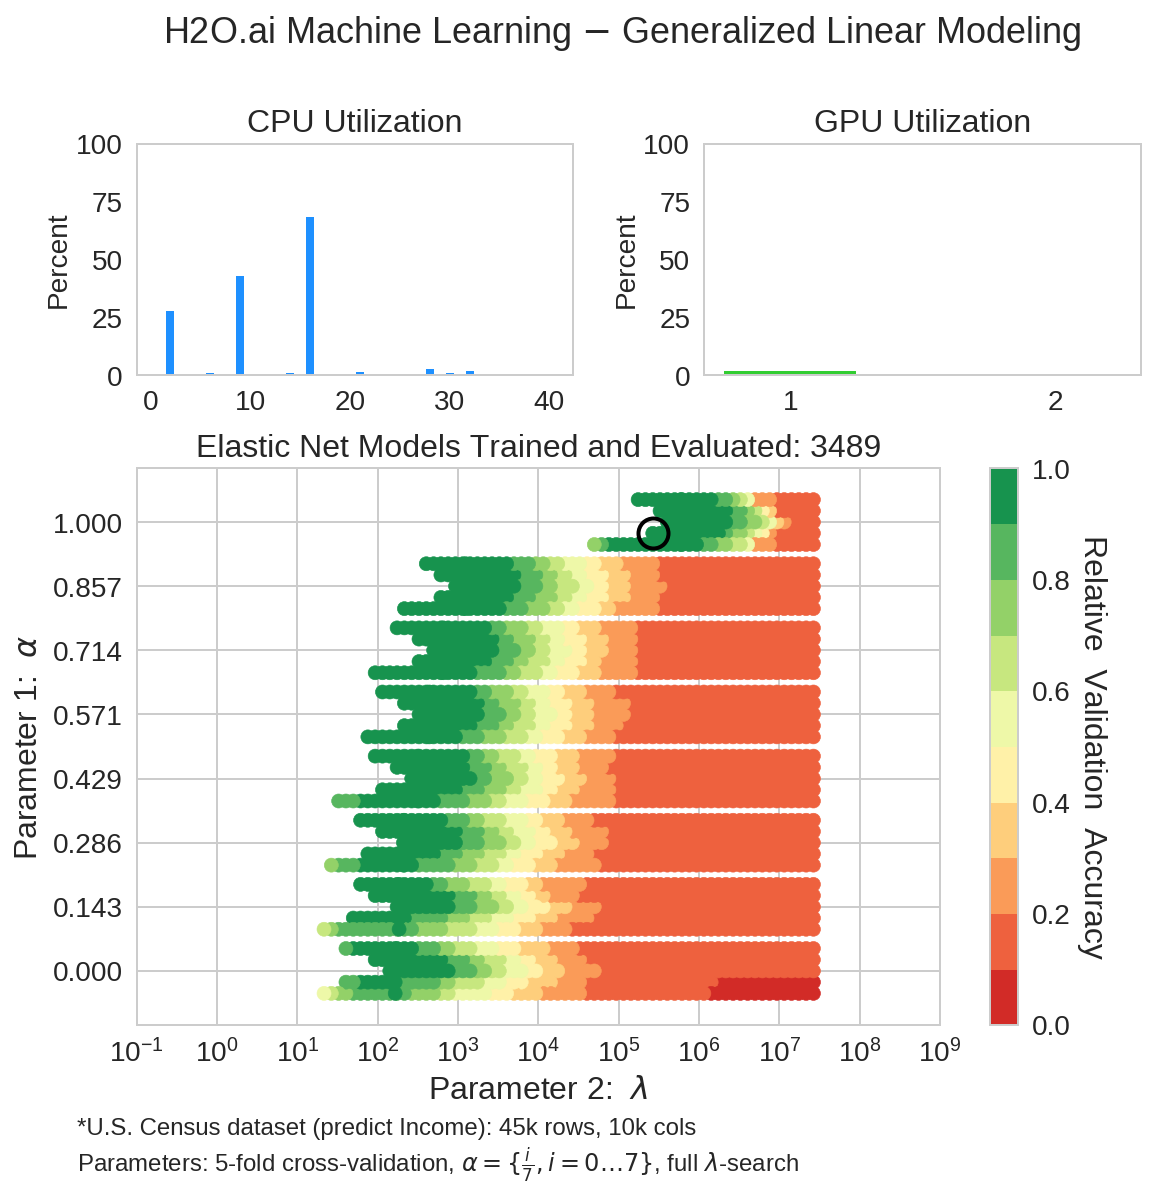

In [ ]:
if run==1 and anim==1:
    # Show Animation
    arg = nGPUs
    RunAnimation(arg)